# Богданов Александр Иванович, Б05-003

## Posterior Sampling в задаче RL

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [15]:
SEED = 11
np.random.seed(SEED)

### Вспомогательные функции

In [16]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []

    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)

            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)
    return episode_rewards

In [18]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.matshow(agent.get_q_matrix().T)
    ax.set_yticklabels(["", "лево", "право"])
    plt.xlabel("Состояние")
    plt.ylabel("Действие")
    plt.title("Значения Q-функции ценности")
    plt.show()

In [20]:
def plot_reward(rews):
    plt.figure(figsize=(15, 8))
    plt.plot(pd.DataFrame.ewm(pd.DataFrame(np.array(rews)),alpha=.1).mean())
    plt.xlabel("Номер эпизода")
    plt.ylabel("Награда")
    plt.show()

### Среда

In [2]:
class RiverSwimEnv:
    LEFT_REWARD = 5.0 / 1000
    RIGHT_REWARD = 1.0

    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()

    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0.0, False

    @property
    def n_actions(self):
        return 2

    @property
    def n_states(self):
        return 2 + self._interm_states

    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0, 1.0, 0]
            else:
                return [1.0, 0, 0]

        elif action == 1:
            if self._current_state == 0:
                return [0, 0.4, 0.6]
            if self._current_state == self.n_states - 1:
                return [0.4, 0.6, 0]
            else:
                return [0.05, 0.6, 0.35]
        else:
            raise RuntumeError(
                "Неизвестное действие {}. Максимальное количество действий {}".format(action, self.n_actions)
            )

    def step(self, action):
        """
        :параметр action:
        :тип данных action: int
        :возвращает: observation, reward, is_done
        :тип возвращаемых данных: (int, float, bool)
        """
        reward = 0.0

        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = np.random.choice(range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD

        self._steps += 1
        return self._current_state, reward, False

### Агенты

Q-обучение агента с $\varepsilon$-жадной стратегией.

In [3]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.2, gamma=0.95, epsilon=0.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        """
        Используется для визуализации политики.
        """
        return self._q_matrix

    def start_episode(self):
        """
        Используется в PSRL агенте.
        """
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = (1 - self._lr) * self._q_matrix[state, action] +\
                                        self._lr * (reward + self._gamma * np.max(self._q_matrix[next_state]))

Сэмплирование по Томпсону для MDP.

In [4]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """ https://en.wikipedia.org/wiki/Normal-gamma_distribution
    """
    tau = np.random.gamma(alpha, beta)
    mu = np.random.normal(mu , 1.0 / np.sqrt(lmbd * tau))
    return mu, tau


class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon
        
        # параметры для сэмплирования матрицы переходов --- распределение Дирихле
        self._transition_counts = np.zeros((n_states, n_states, n_actions)) + 1.0
        
        # параметры для сэмплирования наград --- гамма-нормальное распределение
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._state_action_counts = np.zeros((n_states, n_actions)) + 1.0  # lambda
        
        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.0
        
        
    def _value_iteration(self, transitions, rewards):    
        def Q(values):
            return rewards + np.einsum('ijk,jk->ik', transitions, values[:, None])

        state_values = np.zeros(self._n_states)
        for _ in range(self._horizon):
            state_values = np.max(Q(state_values), axis=1)

        return state_values
    
    def start_episode(self):
        # сэмпл нового Марковского процесса принятия решений
        self._sampled_transitions = np.apply_along_axis(np.random.dirichlet, 1, self._transition_counts)
        
        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            self._mu_matrix,
            self._state_action_counts,
            self._alpha_matrix,
            self._beta_matrix
        )
        

        self._sampled_rewards = sampled_reward_mus
        self._current_value_function = self._value_iteration(self._sampled_transitions, self._sampled_rewards)

    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] + 
                         self._current_value_function.dot(self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):
        
        self._transition_counts[state][next_state][action] += 1
        
        self._mu_matrix[state][action] = (self._mu_matrix[state][action] * self._state_action_counts[state][action] + reward) /\
                                         (self._state_action_counts[state][action] + 1)
        self._beta_matrix[state][action] += 0.5 * self._state_action_counts[state][action] * (reward -  self._mu_matrix[state][action])**2 /\
                                            (self._beta_matrix[state][action] + 1)
        self._state_action_counts[state][action] += 1
        self._alpha_matrix[state][action] += 0.5
        
    def get_q_matrix(self):
        return self._sampled_rewards + self._current_value_function.dot(self._sampled_transitions)

### Обучение

In [26]:
env = RiverSwimEnv()
agent = QLearningAgent(env.n_states, env.n_actions)

In [27]:
rews = train_mdp_agent(agent, env, 1000)

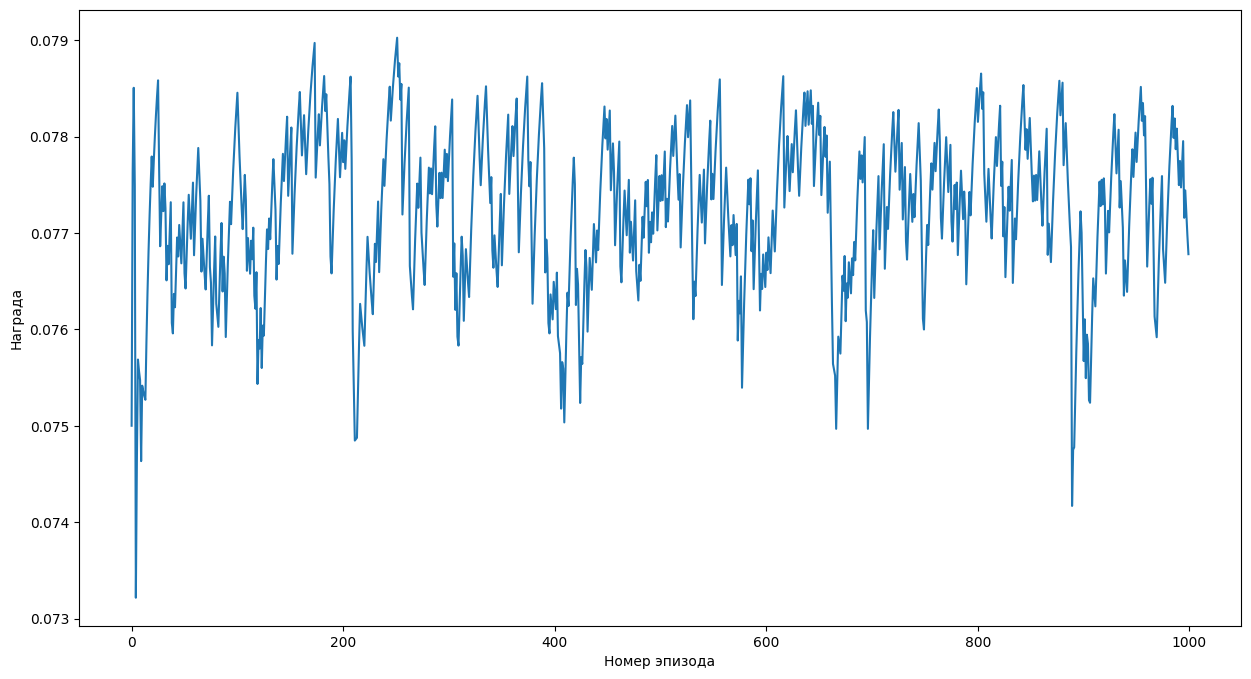

In [28]:
plot_reward(rews)

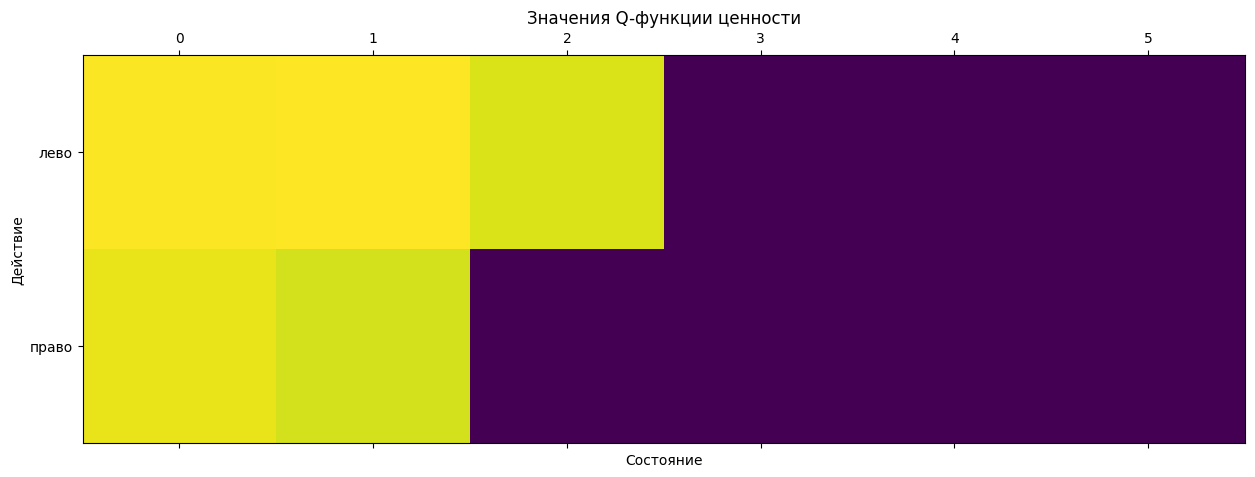

In [29]:
plot_policy(agent)

Видно, что агент использует неоптимальную стратегию и продолжает идти налево, не зная про вариант получше.

In [30]:
horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)

In [31]:
rews = train_mdp_agent(agent, env, 1000)

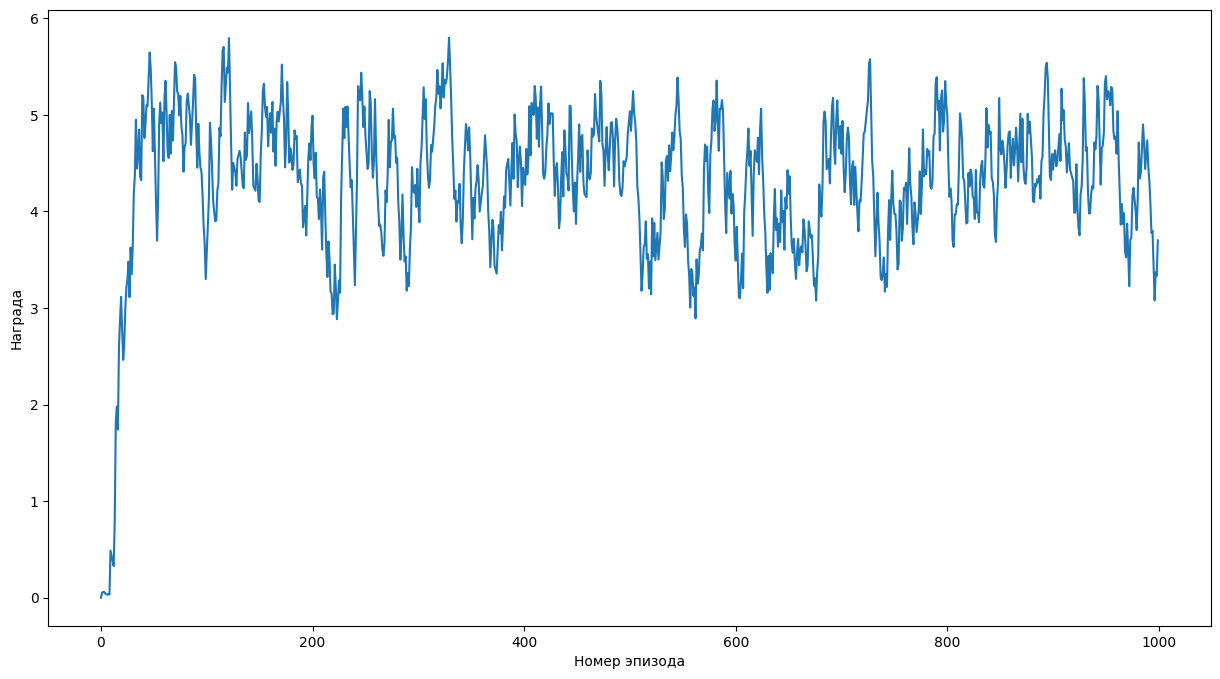

In [32]:
plot_reward(rews)

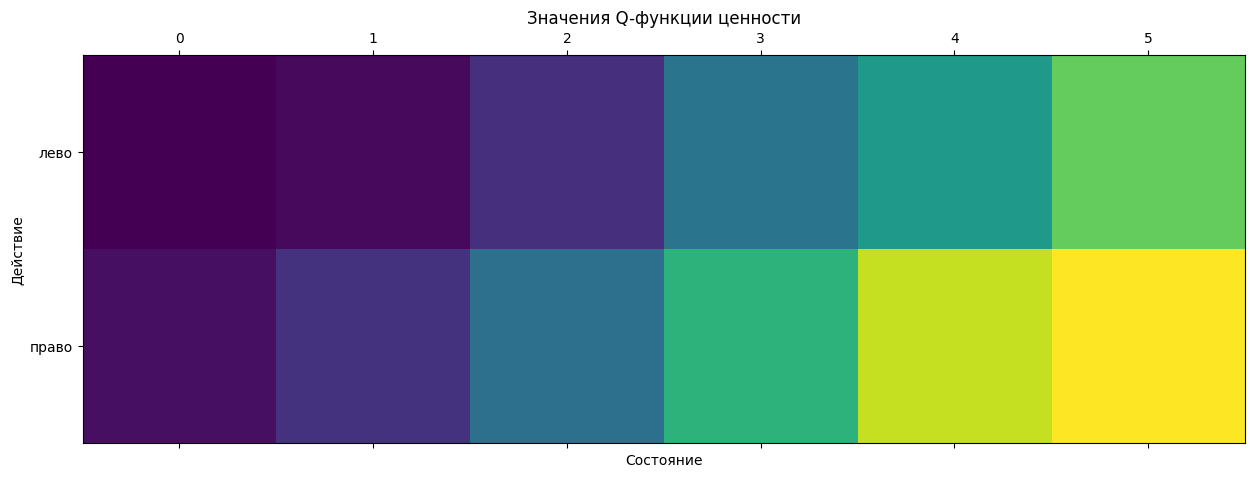

In [33]:
plot_policy(agent)

Использование сэмплирования по Томпсону для MDP приводит к успеху.